<a href="https://www.quantrocket.com"><img alt="QuantRocket logo" src="https://www.quantrocket.com/assets/img/notebook-header-logo.png"></a>

© Copyright Quantopian Inc.<br>
© Modifications Copyright QuantRocket LLC<br>
Licensed under the [Creative Commons Attribution 4.0](https://creativecommons.org/licenses/by/4.0/legalcode).<br>
<a href="https://www.quantrocket.com/disclaimer/">Disclaimer</a>

***
[Quant Finance Lectures (adapted Quantopian Lectures)](Introduction.ipynb) › Lecture 23 - p-Hacking and Multiple Comparisons Bias
***

# p-Hacking and Multiple Comparisons Bias

By Delaney Mackenzie and Maxwell Margenot

<a href="https://youtu.be/YiDfbYtgUPc?t=104" target="_blank">Quantopian video for this lecture ↗</a>

Multiple comparisons bias is a pervasive problem in statistics, data science, and in general forecasting/predictions. The short explanation is that the more tests you run, the more likely you are to get an outcome that you want/expect. If you ignore the multitude of tests that failed, you are clearly setting yourself up for failure by misinterpreting what's going on in your data.

A particularly common example of this is when looking for relationships in large data sets comprising many indepedent series or variables. In this case you run a test each time you evaluate whether a relationship exists between a set of variables.


## Statistics Merely Illuminates This Issue

Most folks also fall prey to multiple comparisons bias in real life. Any time you make a decision you are effectively taking an action based on an hypothesis. That hypothesis is often tested. You can end up unknowingly making many tests in your daily life.

An example might be deciding which medicine is helping cure a cold you have. Many people will take multiple medicines at once to try and get rid of symptoms. You may think that a certain medicine worked, when in reality none did and the cold just happened to start getting better at some point.

The point here is that this problem doesn't stem from statistical testing and p-values. Rather, these techniques give us much more information about the problem and when it might be occuring.

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt

## Refresher: Spearman Rank Correlation

Please refer to [this lecture](Lecture22-Spearman-Rank-Correlation.ipynb) for more full info, but here is a very brief refresher on Spearman Rank Correlation.

It's a variation of correlation that takes into account the ranks of the data. This can help with weird distributions or outliers that would confuse other measures. The test also returns a p-value, which is key here.

A higher coefficient means a stronger estimated relationship.

In [2]:
X = pd.Series(np.random.normal(0, 1, 100))
Y = X

r_s = stats.spearmanr(Y, X)
print('Spearman Rank Coefficient:', r_s[0])
print('p-value:', r_s[1])

Spearman Rank Coefficient: 0.9999999999999999
p-value: 0.0


If we add some noise our coefficient will drop.

In [3]:
X = pd.Series(np.random.normal(0, 1, 100))
Y = X + np.random.normal(0, 1, 100)

r_s = stats.spearmanr(Y, X)
print('Spearman Rank Coefficient:', r_s[0])
print('p-value:', r_s[1])

Spearman Rank Coefficient: 0.5675487548754875
p-value: 7.400429750951024e-10


## p-value Refresher

For more info on p-values see [this lecture](Lecture20-Hypothesis-Testing.ipynb). What's important to remember is that p-values are used to test a hypothesis given some data. Here we are testing the hypothesis that a relationship exists between two series given the series values.

### IMPORTANT: p-values must be treated as binary

A common mistake is that p-values are treated as more or less significant. This is bad practice as it allows for what's known as [p-hacking](https://en.wikipedia.org/wiki/Data_dredging) and will result in more false positives than you expect. Effectively, you will be too likely to convince yourself that relationships exist in your data.

To treat p-values as binary, a cutoff must be set in advance. Then the p-value must be compared with the cutoff and treated as significant/not signficant. Here we'll show this.

### The Cutoff is our Significance Level

We can refer to the cutoff as our significance level because a lower cutoff means that results which pass it are significant at a higher level of confidence. So if you have a cutoff of 0.05, then even on random data 5% of tests will pass based on chance. A cutoff of 0.01 reduces this to 1%, which is a more stringent test. We can therefore have more confidence in our results.

In [4]:
# Setting a cutoff of 5% means that there is a 5% chance
# of us getting a significant p-value given no relationship
# in our data (false positive).
# NOTE: This is only true if the test's assumptions have been
# satisfied and the test is therefore properly calibrated.
# All tests have different assumptions.
cutoff = 0.05

X = pd.Series(np.random.normal(0, 1, 100))
Y = X + np.random.normal(0, 1, 100)

r_s = stats.spearmanr(Y, X)
print('Spearman Rank Coefficient:', r_s[0])
if r_s[1] < cutoff:
    print('There is significant evidence of a relationship.')
else:
    print('There is not significant evidence of a relationship.')

Spearman Rank Coefficient: 0.6767116711671166
There is significant evidence of a relationship.


## Experiment - Running Many Tests

We'll start by defining a data frame.

In [5]:
df = pd.DataFrame()

Now we'll populate it by adding `N` randomly generated timeseries of length `T`.

In [6]:
N = 20
T = 100

for i in range(N):
    X = np.random.normal(0, 1, T)
    X = pd.Series(X)
    name = 'X%s' % i
    df[name] = X

In [7]:
df.head()

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19
0,-0.382880,-1.632254,0.212561,0.790070,-2.553302,0.811507,0.119459,1.809339,-1.838284,-1.026863,0.573714,-1.852624,-1.958859,-0.347150,-0.288394,0.829602,0.780460,-0.324590,0.548732,1.311911
1,-1.397802,0.443193,-0.082494,-0.774512,-0.777737,-0.607087,0.678599,-0.391124,-0.128102,1.331256,-0.615338,-0.056386,0.115522,2.081883,-0.835057,-0.333311,0.173398,2.319136,-0.527261,-0.498879
2,-1.073750,0.048178,-1.281184,-2.217906,-0.136691,0.094427,0.517732,-0.013447,0.514521,0.038735,-0.437818,0.473956,-1.733026,3.005579,0.880455,1.821901,-0.811552,-1.787919,0.552325,-0.628031
3,-0.293104,-1.880268,-2.107173,0.271215,0.616259,0.490665,0.503987,0.855906,1.401176,-1.077987,-1.541610,-0.132718,0.135135,-0.742030,0.710030,-0.526752,1.397659,0.474700,0.972055,-0.739537
4,0.529966,0.433904,0.860538,0.050202,1.064723,0.668131,-0.554399,2.123875,0.566299,-0.579619,0.168401,1.587583,1.687335,-0.330626,0.079690,0.056615,-0.486424,0.140168,0.795738,-0.362579


Now we'll run a test on all pairs within our data looking for instances where our p-value is below our defined cutoff of 5%.

In [8]:
cutoff = 0.05

significant_pairs = []

for i in range(N):
    for j in range(i+1, N):
        Xi = df.iloc[:, i]
        Xj = df.iloc[:, j]
        
        results = stats.spearmanr(Xi, Xj)
        
        pvalue = results[1]
        
        if pvalue < cutoff:
            significant_pairs.append((i, j))

Before we check how many significant results we got, let's run out some math to check how many we'd expect. The formula for the number of pairs given N series is

$$\frac{N(N-1)}{2}$$

There are no relationships in our data as it's all randomly generated. If our test is properly calibrated we should expect a false positive rate of 5% given our 5% cutoff. Therefore we should expect the following number of pairs that achieved significance based on pure random chance.

In [9]:
(N * (N-1) / 2) * 0.05

9.5

Now let's compare to how many we actually found.

In [10]:
len(significant_pairs)

8

We shouldn't expect the numbers to match too closely here on a consistent basis as we've only run one experiment. If we run many of these experiments we should see a convergence to what we'd expect.

### Repeating the Experiment



In [11]:
from IPython.display import clear_output

def do_experiment(N, T, cutoff=0.05):
    df = pd.DataFrame()

    # Make random data
    for i in range(N):
        X = np.random.normal(0, 1, T)
        X = pd.Series(X)
        name = 'X%s' % i
        df[name] = X

    significant_pairs = []

    # Look for relationships
    for i in range(N):
        for j in range(i+1, N):
            Xi = df.iloc[:, i]
            Xj = df.iloc[:, j]

            results = stats.spearmanr(Xi, Xj)

            pvalue = results[1]

            if pvalue < cutoff:
                significant_pairs.append((i, j))
    
    return significant_pairs


num_experiments = 100

results = np.zeros((num_experiments,))

for i in range(num_experiments):
    print(f'trial {i+1} of {num_experiments}')
    clear_output(wait=True)
    
    # Run a single experiment
    result = do_experiment(20, 100, cutoff=0.05)
    
    # Count how many pairs
    n = len(result)
    
    # Add to array
    results[i] = n

print('The average result is:', np.mean(results))

The average result is: 9.45


The average over many experiments should be closer.

## Visualizing What's Going On

What's happening here is that p-values should be uniformly distributed, given no signal in the underlying data. Basically, they carry no information whatsoever and will be equally likely to be 0.01 as 0.99. Because they're popping out randomly, you will expect a certain percentage of p-values to be underneath any threshold you choose. The lower the threshold the fewer will pass your test.

Let's visualize this by making a modified function that returns p-values.

In [12]:
def get_pvalues_from_experiment(N, T):
    df = pd.DataFrame()

    # Make random data
    for i in range(N):
        X = np.random.normal(0, 1, T)
        X = pd.Series(X)
        name = 'X%s' % i
        df[name] = X

    pvalues = []

    # Look for relationships
    for i in range(N):
        for j in range(i+1, N):
            Xi = df.iloc[:, i]
            Xj = df.iloc[:, j]

            results = stats.spearmanr(Xi, Xj)

            pvalue = results[1]

            pvalues.append(pvalue)
    
    return pvalues


We'll now collect a bunch of pvalues. As in any case we'll want to collect quite a number of p-values to start getting a sense of how the underlying distribution looks. If we only collect few, it will be noisy like this:

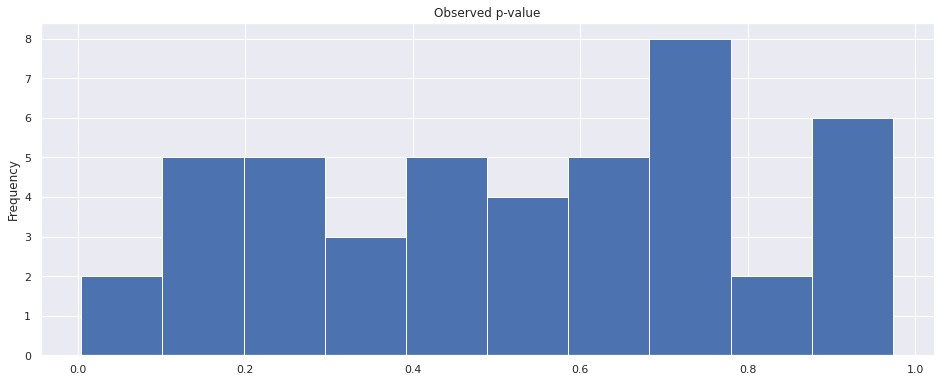

In [13]:
pvalues = get_pvalues_from_experiment(10, 100)
plt.hist(pvalues)
plt.ylabel('Frequency')
plt.title('Observed p-value');

Let's dial up our `N` parameter to get a better sense. Keep in mind that the number of p-values will increase at a rate of

$$\frac{N (N-1)}{2}$$

or approximately quadratically. Therefore we don't need to increase `N` by much.

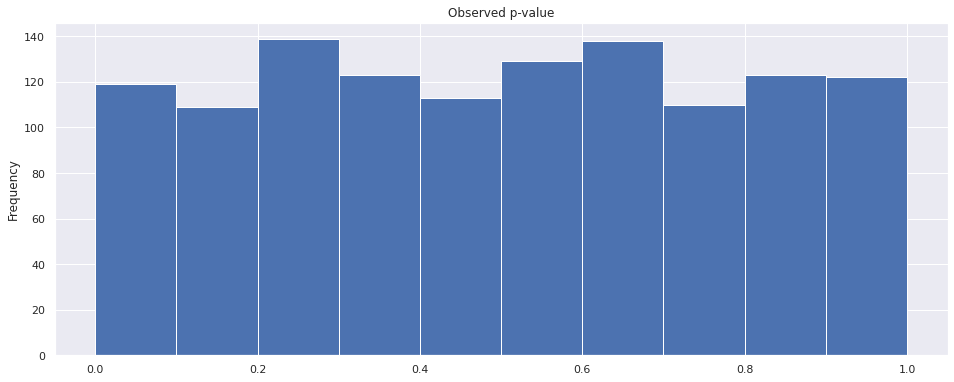

In [14]:
pvalues = get_pvalues_from_experiment(50, 100)
plt.hist(pvalues)
plt.ylabel('Frequency')
plt.title('Observed p-value');

Starting to look pretty flat, as we expected. Lastly, just to visualize the process of drawing a cutoff, we'll draw two artificial lines.

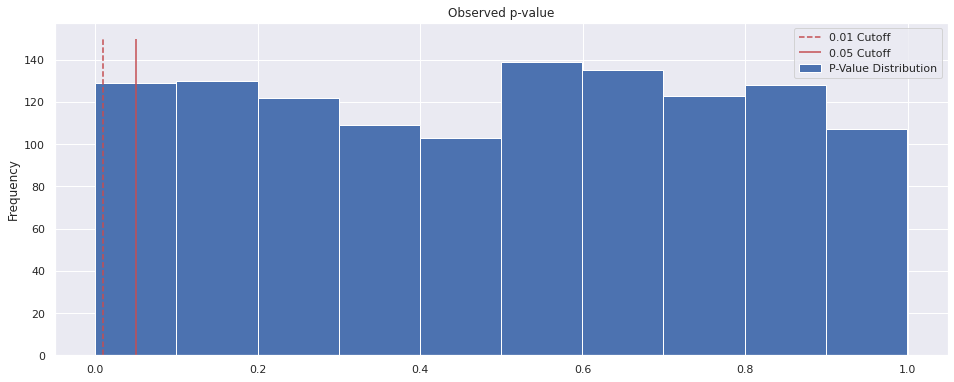

In [15]:
pvalues = get_pvalues_from_experiment(50, 100)
plt.vlines(0.01, 0, 150, colors='r', linestyle='--', label='0.01 Cutoff')
plt.vlines(0.05, 0, 150, colors='r', label='0.05 Cutoff')
plt.hist(pvalues, label='P-Value Distribution')
plt.legend()
plt.ylabel('Frequency')
plt.title('Observed p-value');

We can see that with a lower cutoff we should expect to get fewer false positives. Let's check that with our above experiment.

In [16]:
num_experiments = 100

results = np.zeros((num_experiments,))

for i in range(num_experiments):
    print(f'trial {i+1} of {num_experiments}')
    clear_output(wait=True)
    
    # Run a single experiment
    result = do_experiment(20, 100, cutoff=0.01)
    
    # Count how many pairs
    n = len(result)
    
    # Add to array
    results[i] = n
    
print('The average result is:', np.mean(results))

The average result is: 2.21


And finally compare it to what we expected.

In [17]:
(N * (N-1) / 2) * 0.01

1.9000000000000001

## Sensitivity / Specificity Tradeoff

As with any adjustment of p-value cutoff, we have a tradeoff. A lower cutoff decreases the rate of false positives, but also decreases the chance we find a real relationship (true positive). So you can't just decrease your cutoff to solve this problem.

https://en.wikipedia.org/wiki/Sensitivity_and_specificity

## Reducing Multiple Comparisons Bias

You can't really eliminate multiple comparisons bias, but you can reduce how much it impacts you. To do so we have two options.

### Option 1: Run fewer tests.

This is often the best option. Rather than just sweeping around hoping you hit an interesting signal, use your expert knowledge of the system to develop a great hypothesis and test that. This process of exploring the data, coming up with a hypothesis, then gathering more data and testing the hypothesis on the new data is considered the gold standard in statistical and scientific research. It's crucial that the data set on which you develop your hypothesis is not the one on which you test it. Because you found the effect while exploring, the test will likely pass and not really tell you anything. What you want to know is how consistent the effect is. Moving to new data and testing there will not only mean you only run one test, but will be an 'unbiased estimator' of whether your hypothesis is true. We discuss this a lot in other lectures.

### Option 2: Adjustment Factors and Bon Ferroni Correction

#### WARNING: This section gets a little technical. Unless you're comfortable with significance levels, we recommend looking at the code examples first and maybe reading the linked articles before fully diving into the text.

If you must run many tests, try to correct your p-values. This means applying a correction factor to the cutoff you desire to obtain the one actually used when determining whether p-values are significant. The most conservative and common correction factor is Bon Ferroni.

### Example: Bon Ferroni Correction

The concept behind Bon Ferroni is quite simple. It just says that if we run $m$ tests, and we have a significance level/cutoff of $a$, then we should use $a/m$ as our new cutoff when determining significance. The math works out because of the following.

Let's say we run $m$ tests. We should expect to see $ma$ false positives based on random chance that pass out cutoff. If we instead use $a/m$ as our cutoff, then we should expect to see $ma/m = a$ tests that pass our cutoff. Therefore we are back to our desired false positive rate of $a$.

Let's try it on our experiment above.

In [18]:
num_experiments = 100

results = np.zeros((num_experiments,))

N = 20

T = 100

desired_level = 0.05

num_tests = N * (N - 1) / 2

new_cutoff = desired_level / num_tests

for i in range(num_experiments):
    
    print(f'trial {i+1} of {num_experiments}')
    clear_output(wait=True)
    
    # Run a single experiment
    result = do_experiment(20, 100, cutoff=new_cutoff)
    
    # Count how many pairs
    n = len(result)
    
    # Add to array
    results[i] = n
    
print('the average result is:', np.mean(results))

the average result is: 0.07


As you can see, our number of significant results is now far lower on average. Which is good because the data was random to begin with.

### These are Often Overly Conservative

Because Bon Ferroni is so stringent, you can often end up passing over real relationships. There is a good example in the following article

https://en.wikipedia.org/wiki/Multiple_comparisons_problem

Effectively, it assumes that all the tests you are running are independent, and doesn't take into account any structure in your data. You may be able to design a more finely tuned correction factor, but this is adding a layer of complexity and therefore a point of failure to your research. In general any time you relax your stringency, you need to be very careful not to make a mistake.

Because of the over-zealousness of Bon Ferroni, often running fewer tests is the better option. Or, if you must run many tests, reserve multiple sets of data so your candidate signals can undergo an out-of-sample round of testing. For example, you might have the following flow:

 * Let's say there are 100,000 possible relationships.
 * Run a test on each possible relationship, and pick those that passed the test.
 * With these candidates, run a test on a new out-of-sample set of data. Because you have many fewer candidates, you can now apply a Bon Ferroni correction to these p-values, or if necessary repeat another round of out-of-sample testing.

## What is p-Hacking?

p-hacking is just intentional or accidental abuse of multiple comparisons bias. It is surprisingly common, even in academic literature. The excellent statistical news website FiveThirtyEight has a great visualization here:

https://fivethirtyeight.com/features/science-isnt-broken/

Wikipedia's article is also informative:

https://en.wikipedia.org/wiki/Data_dredging

In general, the concept is simple. By running many tests or experiments and then focusing only on the ones that worked, you can present false positives as real results. Keep in mind that this also applies to running many different models or different types of experiments and on different data sets. Imagine that you spend a summer researching a new model to forecast corn future prices. You try 50 different models until finally one succeeds. Is this just luck at this point? Certainly you would want to be more careful about validating that model and testing it out-of-sample on new data before believing that it works.

## Final Notes

### You can never eliminate, only reduce risk.

In general you can never completely eliminate multiple comparisons bias, you can only reduce the risk of false positives using techniques we described above. At the end of the day most ideas tried in research don't work, so you'll end up testing many different hypotheses over time. Just try to be careful and use common sense about whether there is sufficient evidence that a hypothesis is true, or that you just happened to get lucky on this iteration.

### Use Out-of-Sample Testing

As mentioned above, out-of-sample testing is one of the best ways to reduce your risk. You should always use it, no matter the circumstances. Often one of the ways that false positives make it through your workflow is a lack of an out-of-sample test at the end.

## Sources

 * https://en.wikipedia.org/wiki/Multiple_comparisons_problem
 * https://en.wikipedia.org/wiki/Sensitivity_and_specificity
 * https://en.wikipedia.org/wiki/Bonferroni_correction
 * https://fivethirtyeight.com/features/science-isnt-broken/

---

**Next Lecture:** [Leverage](Lecture24-Leverage.ipynb) 

[Back to Introduction](Introduction.ipynb) 

---

*This presentation is for informational purposes only and does not constitute an offer to sell, a solicitation to buy, or a recommendation for any security; nor does it constitute an offer to provide investment advisory or other services by QuantRocket LLC ("QuantRocket"). Nothing contained herein constitutes investment advice or offers any opinion with respect to the suitability of any security, and any views expressed herein should not be taken as advice to buy, sell, or hold any security or as an endorsement of any security or company.  In preparing the information contained herein, the authors have not taken into account the investment needs, objectives, and financial circumstances of any particular investor. Any views expressed and data illustrated herein were prepared based upon information believed to be reliable at the time of publication. QuantRocket makes no guarantees as to their accuracy or completeness. All information is subject to change and may quickly become unreliable for various reasons, including changes in market conditions or economic circumstances.*